# Anomaly detection on CPU usage

You will put on practice a lot of skills and your time series new knowledge to try improving a default prediction model.
You can use the resources provided in the course, Arima method, Prophet method, and of course continue looking for additional resources if you wish to have a different approach to the problem.


# Task -  

- Anomaly Detection means to identify unexpected events in a process. It means to detect threats to our systems that may cause harm in terms of security and leakage of important information, but the importance of Anomaly Detection is not limited to security. 
- The data of this project is based on per-minute metrics of the host’s CPU utilization.

In [21]:
!pip install -r ../requirements.txt

  Using cached SQLAlchemy-1.4.37-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached PyMySQL-1.0.2-py3-none-any.whl (43 kB)
  Using cached python_dotenv-0.20.0-py3-none-any.whl (17 kB)
  Using cached psycopg2_binary-2.9.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
  Using cached ipyleaflet-0.17.0-py2.py3-none-any.whl (3.3 MB)
  Using cached sympy-1.10.1-py3-none-any.whl (6.4 MB)
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [22]:
import pandas as pd
import numpy as np 

from datetime import datetime

import seaborn as sns
import cufflinks as cf
import plotly.offline as py
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime






**Step 2** Load datasets

In [23]:
train_a = pd.read_csv('../data/raw/cpu-train-a.csv')
train_b= pd.read_csv('../data/raw/cpu-train-b.csv')

test_a = pd.read_csv('../data/raw/cpu-test-a.csv')
test_b = pd.read_csv('../data/raw/cpu-test-b.csv')

**Step 3** Dataset overview

In [24]:
train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  420 non-null    object 
 1   cpu       420 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB


In [25]:
train_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  600 non-null    object 
 1   cpu       600 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.5+ KB


In [26]:
train_a['datetime']=train_a['datetime'].astype('datetime64')
train_b['datetime']=train_b['datetime'].astype('datetime64')
test_a['datetime']=test_a['datetime'].astype('datetime64')
test_b['datetime']=test_b['datetime'].astype('datetime64')

In [27]:
train_a.describe(datetime_is_numeric=True)

,datetime,cpu
count,420,420.000000
mean,2017-01-27 22:11:29.999999744,1.233262
min,2017-01-27 18:42:00,0.570000
25%,2017-01-27 20:26:45,0.787500
50%,2017-01-27 22:11:30,1.110000
75%,2017-01-27 23:56:15,1.582500
max,2017-01-28 01:41:00,2.550000
std,NaN,0.505668


In [28]:
train_b.describe(datetime_is_numeric=True)

,datetime,cpu
count,600,600.000000
mean,2017-01-27 23:41:30,1.282733
min,2017-01-27 18:42:00,0.570000
25%,2017-01-27 21:11:45,0.840000
50%,2017-01-27 23:41:30,1.240000
75%,2017-01-28 02:11:15,1.610000
max,2017-01-28 04:41:00,2.550000
std,NaN,0.484951


In [29]:
test_a.describe(datetime_is_numeric=True)

,datetime,cpu
count,60,60.000000
mean,2017-01-28 02:11:29.999999744,1.271500
min,2017-01-28 01:42:00,0.680000
25%,2017-01-28 01:56:45,0.902500
50%,2017-01-28 02:11:30,1.210000
75%,2017-01-28 02:26:15,1.562500
max,2017-01-28 02:41:00,2.190000
std,NaN,0.418309


In [30]:
test_b.describe(datetime_is_numeric=True)

,datetime,cpu
count,60,60.000000
mean,2017-01-28 05:11:30,1.345833
min,2017-01-28 04:42:00,0.030000
25%,2017-01-28 04:56:45,0.070000
50%,2017-01-28 05:11:30,1.605000
75%,2017-01-28 05:26:15,2.150000
max,2017-01-28 05:41:00,2.830000
std,NaN,0.954620


We can see that train_a and test_a overlap in dates, the same is true for train_b and test_b. So, we assume that each group makes up a data set and for each dataset we will fit the same model and see how it fits.

In [31]:
train_a.set_index('datetime',inplace=True)
test_a.set_index('datetime',inplace=True)
train_b.set_index('datetime',inplace=True)
test_b.set_index('datetime',inplace=True)

In [32]:
train_a.sample(10)

,cpu
datetime,
2017-01-27 22:35:00,1.27
2017-01-27 22:02:00,0.70
2017-01-28 00:39:00,0.99
2017-01-27 19:55:00,0.78
2017-01-28 01:40:00,2.14
2017-01-27 20:24:00,1.88
2017-01-27 23:24:00,1.75
2017-01-27 19:19:00,0.68
2017-01-27 20:41:00,1.72


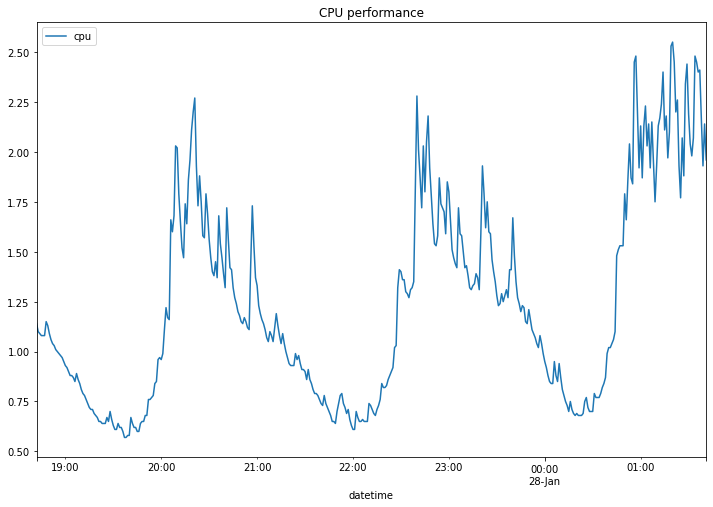

In [33]:
train_a.plot(title='CPU performance',figsize=(12,8))
plt.show()

It looks like there is a seasonality each two hours and a trend, altought it is very low. Maybe with a descomposition analysis it is easier to see.

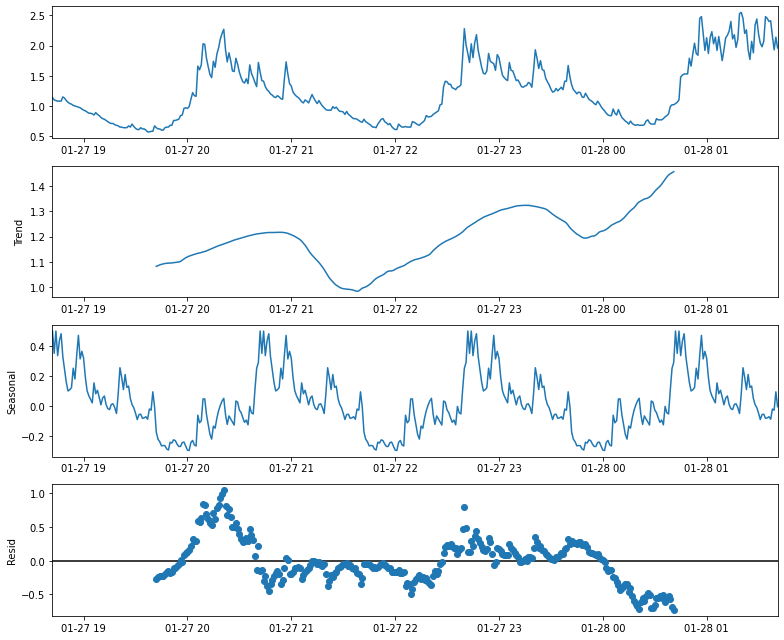

In [34]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(train_a,model='additive',period=60*2) # 2 hours period, the datetime is in minutes
fig = decomposition.plot()
plt.show()

Although we have a few observations to say anything with any certainty, we can see the seasonal component of the data, and we can also see a slightly upward trend of the data. It makes sense to use a Seasonal ARIMA model. In order to do this we will need to choose p,d,q values for the ARIMA, and P,D,Q values for the Seasonal component.

**Step 4** Seasonal ARIMA model

Looking for the best parameters.

In [35]:
stepwise_model = auto_arima(train_a, start_p=1, start_q=1,
                           max_p=1, max_q=1, m=60*2,
                           start_P=0, seasonal=True,
                           d=1, D=1,max_P=1,max_Q=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,random_state=608)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[120]             : AIC=inf, Time=360.12 sec
 ARIMA(0,1,0)(0,1,0)[120]             : AIC=-187.268, Time=20.59 sec
 ARIMA(1,1,0)(1,1,0)[120]             : AIC=inf, Time=139.11 sec
 ARIMA(0,1,1)(0,1,1)[120]             : AIC=inf, Time=385.93 sec
 ARIMA(0,1,0)(1,1,0)[120]             : AIC=inf, Time=486.00 sec


In [ ]:
stepwise_model.fit(train_a) #fit the best model

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 1, 0, 120),
      suppress_warnings=True, with_intercept=False)

**Step 5** Evaluate the performance

Visual evaluation

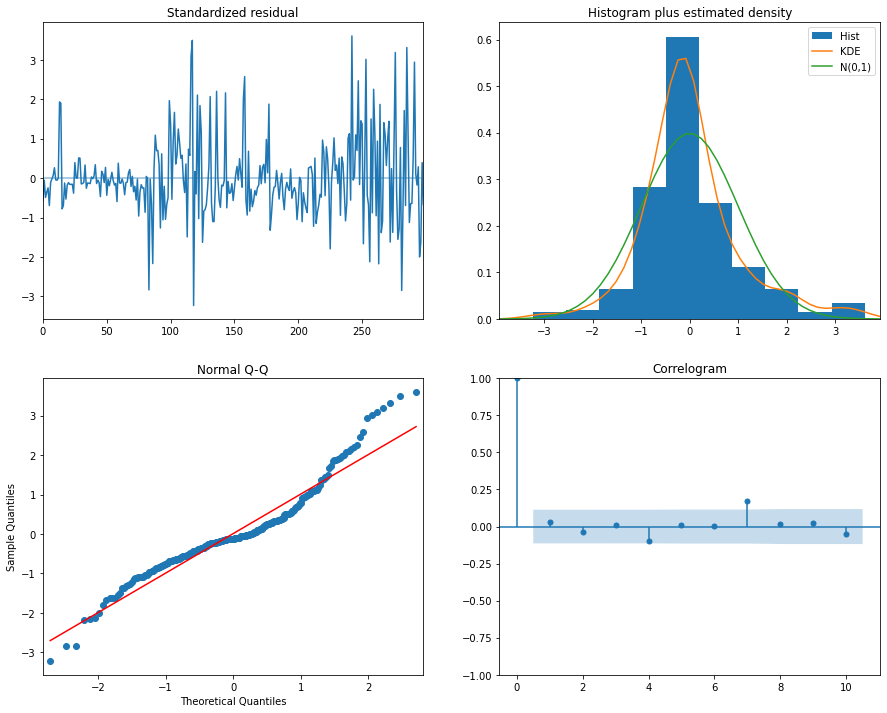

In [ ]:
stepwise_model.fit(train_a).plot_diagnostics(figsize=(15, 12))
plt.show()

This is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean.

It is observed that the distribution of the residuals does not fit perfectly to a standard normal distribution. One could try to run the model by increasing the maximum number of residuals included, the differences and the moving averages, both the structural and the seasonal components.

Note: an attempt was made to run a model with a maximum of 2 residuals and 2 differences but it took a long time (indeed it run for 6 hours) and the session was closed.

Forcasting with the model fitted

In [ ]:
future_forecast_a = stepwise_model.predict(n_periods=60) # One hour forcast

**Step 6** Actual plus prediction // Real future plus prediction

<AxesSubplot:title={'center':'Actual plus predict CPU incidences'}, xlabel='datetime'>

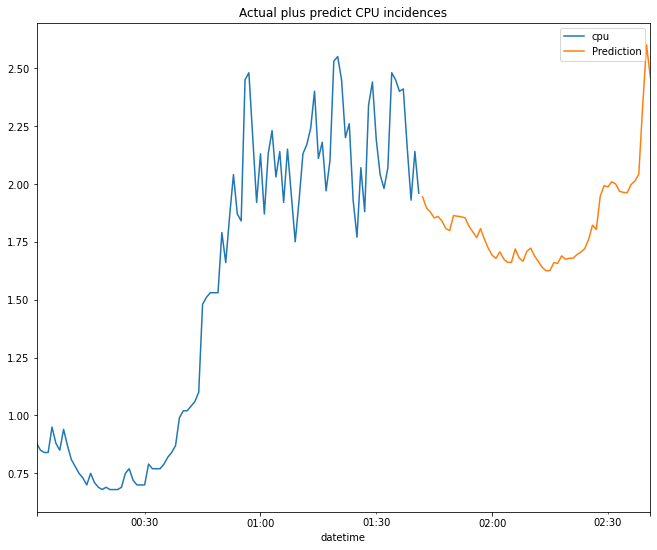

In [ ]:
future_forecast_a = pd.DataFrame(future_forecast_a,index = test_a.index,columns=['Prediction'])
pd.concat([train_a.tail(100),future_forecast_a],axis=0).plot(title='Actual plus predict CPU incidences')

It is observed that the forecast reflects the decrease at 2 am respecting the seasonal component.

<AxesSubplot:title={'center':'Real future plus predict CPU incidences'}, xlabel='datetime'>

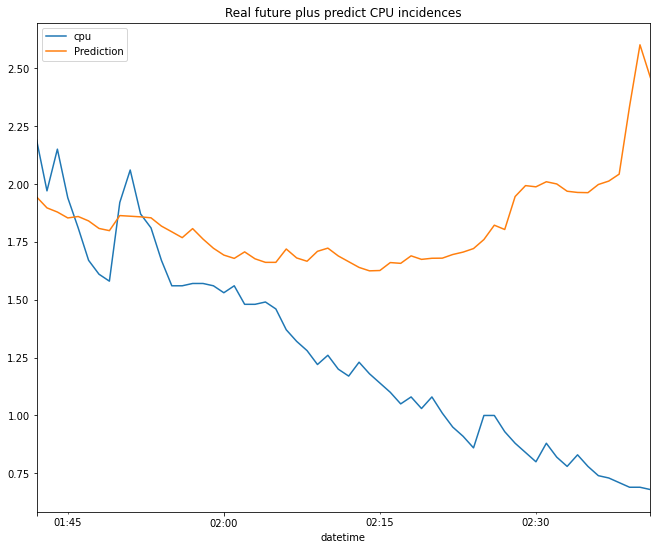

In [ ]:
pd.concat([test_a,future_forecast_a],axis=1).plot(title='Real future plus predict CPU incidences')

On one hand, it is observed that the training sample does not seem to have the same seasonal behavior as the training sample; in fact, the incidences do not increase after the two, but seem to continue to decrease. On the other hand, related to the above, the prediction made by the model is far from reality.

In [ ]:
# Save the model as a pickle
filename = '../models/best_model_a.pkl'
pickle.dump(stepwise_model, open(filename,'wb'))

**Step 7** Refitting the model

In [ ]:
stepwise_model.fit(train_b)
future_forecast_b = stepwise_model.predict(n_periods=60)

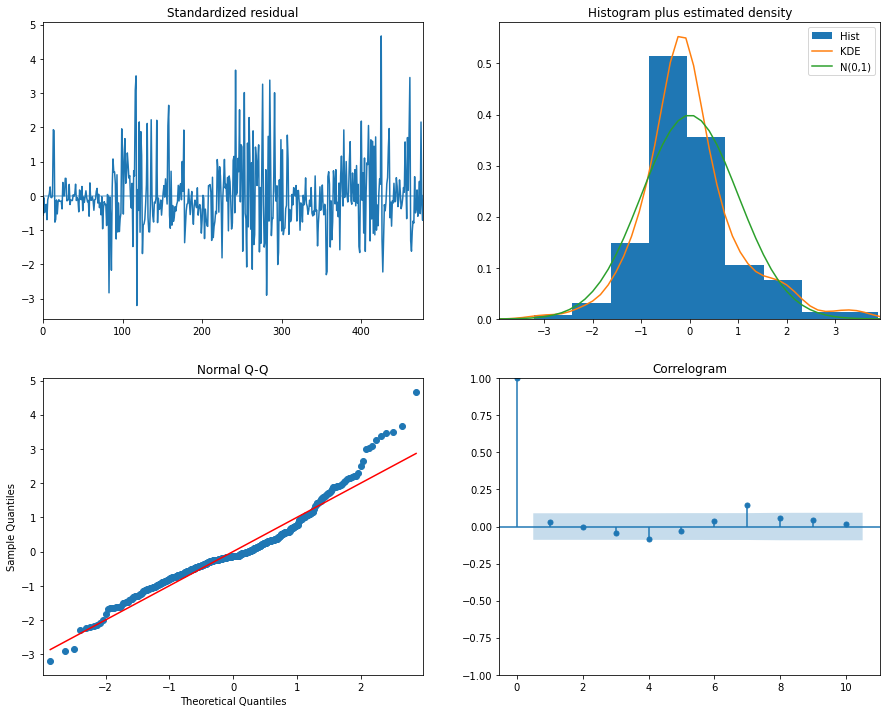

In [ ]:
stepwise_model.fit(train_b).plot_diagnostics(figsize=(15, 12))
plt.show()

It was the same as with the other training test.

<AxesSubplot:title={'center':'Real future plus predict CPU incidences'}, xlabel='datetime'>

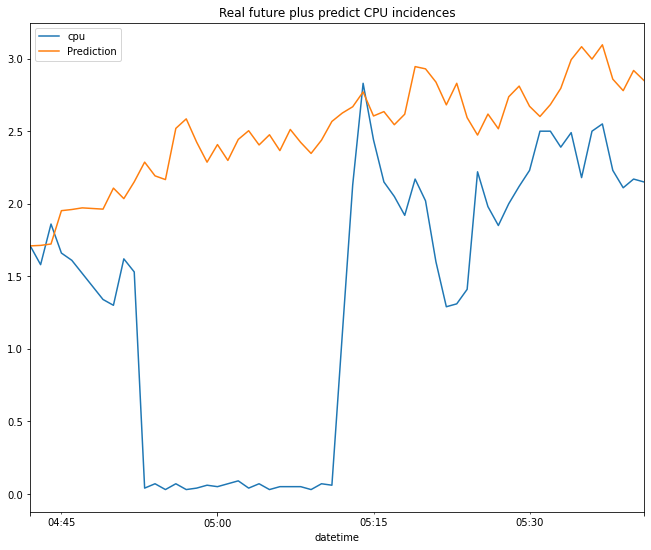

In [ ]:
future_forecast_b = pd.DataFrame(future_forecast_b,index = test_b.index,columns=['Prediction'])
pd.concat([test_b,future_forecast_b],axis=1).plot(title='Real future plus predict CPU incidences')

However, in the sample of test b there is a sharp decrease at 5 am that does not coincide with the seasonal component. It seems to be an outlier, so it is impossible to predict. In fact, if we look at the rest of the prediction, it seems to be very close to reality.

In [ ]:
# Save the model as a pickle
filename = '../models/best_model_b.pkl'
pickle.dump(stepwise_model, open(filename,'wb'))